# Final Project Submission

Please fill out:
* Student name: Peder Norr
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION

A smart understanding of which water pumps will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.
This proposal contains an analysis of Tanzanian water pump data in order to provide the Tanzania Ministry of Water a tool with which to determine water pump functionality and information on how to improve pump maintenance efficiency. Initial analysis of water pump data shows that the location of a pump, the age of a pump, the size of population surrounding the pump, and the quantity of water a pump has access to are the biggest indicators of a pumps's functionality status. The Tanzanian Ministry of Water can use this analysis to improve prediction and identification of which pumps are non functional or may need repair, therefore increasing access to potable water across Tanzania.

## Business Problem

The Tanzania Ministry of Water is trying to improve their water pump maintenance operations in order to ensure that clean, potable water is available to communities across Tanzania. In order to accomplish this, the Ministry wants to be able to better predict which pumps will fail, and to better identify pumps that need repair now. This is in hopes of improving maintenance efficiency and water access. Using water pump data, I create a model that can help identify pumps needing repair and characteristics that may indicate pump failure in the future.


# OBTAIN

## Data Understanding

The data used in this analysis come from the Taarifa waterpoints dashboard, which aggregates data from the Tanzania Ministry of Water, by way of the [DrivenData Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/) competition. The data set contains  41 variables describing pump functionality status (the target variable), pump geographic location, what kind of pump is operating, when it was installed, how it is managed, etc. It includes data on 59,400 individual pumps recorded from 2011-2013.

In [63]:
#Import necessary packages

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import missingno as missingno

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

from xgboost import XGBRFClassifier, XGBClassifier

from imblearn.over_sampling import SMOTE,SMOTENC

#!pip install yellowbrick
from yellowbrick.classifier import ROCAUC

#!pip install lime
from lime.lime_tabular import LimeTabularExplainer

In [64]:
#Set pandas and seaborn options

pd.set_option('display.max_columns',0)
plt.style.use('seaborn-notebook')
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [65]:
#Import X data

training_values_df= pd.read_csv('data/training-set-values.csv')
training_values_df

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.00000000,2013-05-03,Germany Republi,1210,CES,37.16980689,-3.25384746,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.00000000,2011-05-07,Cefa-njombe,1212,Cefa,35.24999126,-9.07062880,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.00000000,2011-04-11,NaN,0,NaN,34.01708706,-8.75043433,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.00000000,2011-03-08,Malec,0,Musa,35.86131531,-6.37857327,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [66]:
#Import Y data

training_labels_df = pd.read_csv('data/training-set-labels.csv')
training_labels_df

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional
...,...,...
59395,60739,functional
59396,27263,functional
59397,37057,functional
59398,31282,functional


In [67]:
#Combine dataframes to create complete dataframe

raw_training_df = pd.merge(training_labels_df, training_values_df)
raw_training_df

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,functional,10.00000000,2013-05-03,Germany Republi,1210,CES,37.16980689,-3.25384746,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,functional,4700.00000000,2011-05-07,Cefa-njombe,1212,Cefa,35.24999126,-9.07062880,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,functional,0.00000000,2011-04-11,NaN,0,NaN,34.01708706,-8.75043433,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,functional,0.00000000,2011-03-08,Malec,0,Musa,35.86131531,-6.37857327,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [68]:
#Create copy of raw data frame to iterate on

training_df = raw_training_df.copy()
training_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [69]:
#Dispay data frame info

training_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

# SCRUB

In [70]:
#Check data for duplicates

duplicates = training_df.duplicated(keep = False)
duplicates.value_counts()

False    59400
dtype: int64

No duplicates!

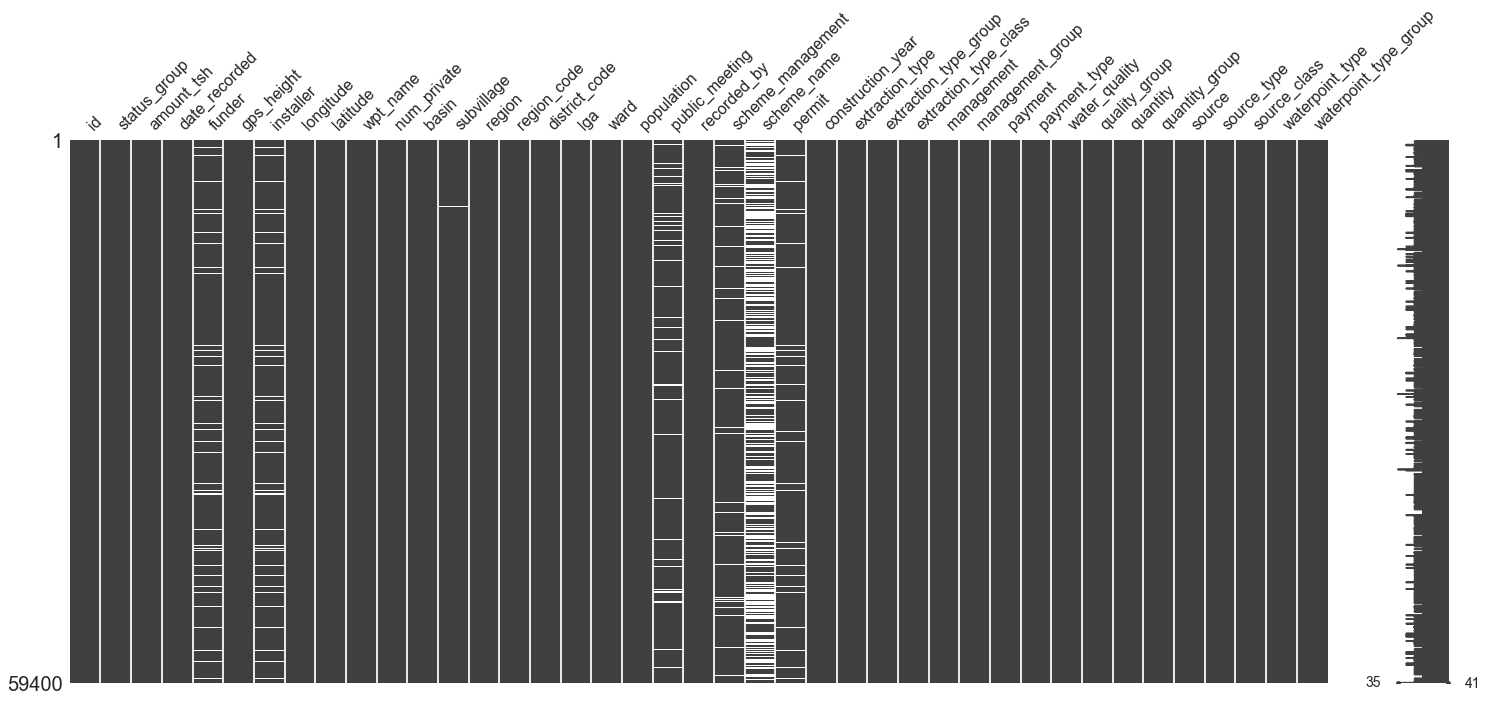

,#null,%null
id,0,0.00000000
status_group,0,0.00000000
amount_tsh,0,0.00000000
date_recorded,0,0.00000000
funder,3635,6.12000000
gps_height,0,0.00000000
installer,3655,6.15000000
longitude,0,0.00000000
latitude,0,0.00000000
wpt_name,0,0.00000000


In [71]:
#Check for null values

#Original source https://github.com/flatiron-school/Online-DS-FT-022221-Cohort-Notes/blob/master/Phase_3/topic_30_ensemble_methods/topic_30_ensemble_methods-SG.ipynb

missingno.matrix(training_df)
plt.show()
null_check = pd.DataFrame({
    '#null':training_df.isna().sum(),
    '%null':round(training_df.isna().sum()/len(training_df)*100,2)
})
null_check


In [72]:
#Check for nulls that may be represented by zeros by showing unique values for
#each feature

for column in training_df:
    print(training_df[column].value_counts(dropna=False).head(30))
    print("Number of unique values: ")
    print(len(training_df[column].value_counts()))
    print()

2047     1
72310    1
49805    1
51852    1
62091    1
64138    1
57993    1
60040    1
33413    1
35460    1
45699    1
41601    1
43648    1
70263    1
68212    1
20442    1
23134    1
19036    1
29275    1
25177    1
27224    1
4695     1
6742     1
597      1
2644     1
10832    1
53839    1
55886    1
55950    1
53903    1
Name: id, dtype: int64
Number of unique values: 
59400

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
Number of unique values: 
3

0.00000000        41639
500.00000000       3102
50.00000000        2472
1000.00000000      1488
20.00000000        1463
200.00000000       1220
100.00000000        816
10.00000000         806
30.00000000         743
2000.00000000       704
250.00000000        569
300.00000000        557
5000.00000000       450
5.00000000          376
25.00000000         356
3000.00000000       334
1200.00000000       267
1500.00000000       197
6.00000000          1

True     51011
False     5055
NaN       3334
Name: public_meeting, dtype: int64
Number of unique values: 
2

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64
Number of unique values: 
1

VWC                 36793
WUG                  5206
NaN                  3877
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64
Number of unique values: 
12

NaN                                      28166
K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water sup

In [73]:
training_df.nunique()

id                       59400
status_group                 3
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_qu

### Train-Test-Split

In [74]:
# Conduct train test split to create training and testing data groups for
# future modeling

y = training_df['status_group'].copy()
X = training_df.drop(columns=['status_group']).copy()

X_train, X_test, y_train,y_test  = train_test_split(X,y,test_size=.3,
                                                    random_state=4,
                                                    stratify=y)
y_train.value_counts(normalize=True)

functional                0.54307359
non functional            0.38424723
functional needs repair   0.07267917
Name: status_group, dtype: float64

In [75]:
#Continue check for nulls

X_train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2555
gps_height                   0
installer                 2570
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 269
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2313
recorded_by                  0
scheme_management         2707
scheme_name              19794
permit                    2155
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

Remove unnecessary columns:
* `id` I determined to be irrelevant to the model
- `amount_tsh` is ~70% zeros
*`date_recorded` I determined to be irrelevant to the model
*`num_private` is is ~99% zeros and I was unable to find a definition for the feature
*`recorded_by` I determined to be irrelevant to the model
* `payment_type` I determined to be equivalent to `payment` and therefore redundant
* `quantity_group` I determined to be nearly equivalent to `quantity` and therefore redundant
* `waterpoint_type_group` I determined to be nearly eqivalent to `waterpoint_type` and therefore redundant
* `scheme_name` is  ~50% nulls
* `subvillage` This feature has an unrealistic number of values to OneHotEncode and can be captured by other geographic features
* `wpt_name` I determined to be irrelevant to the model and has too many values
*`funder` has too many values to model
*`installer` has too many values to model
*`ward` has too many values to model

In [76]:
#Remove unnecessary columns

columns = ['id','amount_tsh',  'num_private', 'date_recorded', 
          'quantity_group', 'recorded_by','payment_type', 
          'waterpoint_type_group', 'scheme_name', 'subvillage', 'wpt_name',
            'funder', 'installer', 'ward']

X_train.drop(columns, axis=1, inplace=True)
X_test.drop(columns, axis=1, inplace=True)
    

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [77]:
display(X_train.head())
X_test.head()

,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
25389,0,35.74608634,-6.38085616,Rufiji,Dodoma,1,5,Dodoma Urban,0,True,VWC,False,0,mono,mono,motorpump,vwc,user-group,never pay,soft,good,dry,machine dbh,borehole,groundwater,other
53681,0,31.38982125,-2.70377602,Lake Victoria,Kagera,18,4,Biharamulo,0,True,VWC,True,0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,improved spring
36183,256,36.91014012,-7.83640050,Rufiji,Morogoro,5,3,Kilombero,150,True,WUA,True,1978,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe
50163,0,33.67400613,-3.74998506,Internal,Shinyanga,17,8,Kishapu,0,False,Parastatal,False,0,gravity,gravity,gravity,parastatal,parastatal,unknown,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe
4794,0,33.04266426,-2.49822022,Lake Victoria,Mwanza,19,2,Magu,0,True,VWC,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump


,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type
31860,0,30.63997958,-2.78726126,Lake Victoria,Kagera,18,30,Ngara,0,True,VWC,False,0,india mark iii,india mark iii,handpump,vwc,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump
50731,0,33.95774304,-9.40296009,Lake Nyasa,Mbeya,12,3,Kyela,0,True,VWC,True,0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,enough,spring,spring,groundwater,communal standpipe
37529,0,35.98917543,-5.88782909,Wami / Ruvu,Dodoma,1,5,Dodoma Urban,0,True,VWC,False,0,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,spring,spring,groundwater,communal standpipe
41990,952,29.74053072,-4.75518579,Lake Tanganyika,Kigoma,16,3,Kigoma Rural,165,True,VWC,True,2005,gravity,gravity,gravity,wug,user-group,pay monthly,soft,good,enough,river,river/lake,surface,communal standpipe multiple
51897,1300,31.21231465,-8.43149966,Lake Tanganyika,Rukwa,15,2,Sumbawanga Rural,450,True,VWC,True,1986,gravity,gravity,gravity,vwc,user-group,never pay,soft,good,insufficient,river,river/lake,surface,communal standpipe


Address columns that have nulls represented by zeros

In [78]:
# Replace zeros for median for gps_height and population

columns = ['gps_height', 'population']

for column in columns:
    X_train[column].replace(0, X_train[column].median() , inplace=True)
    X_test[column].replace(0, X_train[column].median() , inplace=True)
    
display(X_train['gps_height'].value_counts())
X_test['gps_height'].value_counts()


C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

 374     14322
-15         43
-13         42
-16         41
 1286       39
         ...  
 2172        1
 2261        1
-90          1
 2120        1
 2186        1
Name: gps_height, Length: 2372, dtype: int64

 374     6136
-18        20
-19        20
 1602      18
 1290      18
         ... 
 2134       1
 2166       1
 2182       1
 2198       1
 2049       1
Name: gps_height, Length: 2214, dtype: int64

In [79]:
display(X_train['population'].value_counts())
X_test['population'].value_counts()

27      15024
1        4816
200      1349
150      1323
250      1166
        ...  
3014        1
1831        1
1863        1
975         1
1439        1
Name: population, Length: 942, dtype: int64

27      6362
1       2209
200      591
150      569
250      515
        ... 
731        1
635        1
619        1
421        1
1375       1
Name: population, Length: 659, dtype: int64

In [80]:
# Replace zeros with median for construction_year

X_train['construction_year'].replace(0, X_train['construction_year'].median(),
                                     inplace=True)
X_test['construction_year'].replace(0, X_train['construction_year'].median(),
                                    inplace=True)

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [81]:
display(X_train['construction_year'].value_counts())
X_test['construction_year'].value_counts()

1986    14856
2008     1835
2010     1809
2009     1751
2000     1506
2007     1151
2006     1029
2003      900
2011      862
2004      802
2002      748
2012      744
2005      707
1995      703
1999      702
1978      695
1990      686
1998      668
1985      662
1996      567
1980      563
1984      545
1982      525
1994      520
1972      510
1974      462
1997      450
1992      449
1993      420
2001      385
1988      363
1983      338
1975      307
1970      284
1976      280
1991      225
1989      214
1987      214
1981      163
1977      138
1979      136
1973      130
2013      119
1971       91
1960       70
1967       63
1963       58
1968       48
1969       42
1964       24
1962       23
1965       15
1961       15
1966        8
Name: construction_year, dtype: int64

1986    6287
2010     836
2009     782
2008     778
2000     585
2006     442
2007     436
2011     394
2003     386
1978     342
2012     340
2002     327
2004     321
1995     311
2005     304
1998     298
1985     283
1999     277
1990     268
1980     248
1996     244
1984     234
1982     219
1994     218
1974     214
1972     198
1997     194
1992     191
1993     188
1988     158
2001     155
1983     150
1976     134
1975     130
1970     127
1989     102
1991      99
1987      88
1981      75
1977      64
2013      57
1979      56
1971      54
1973      54
1960      32
1968      29
1963      27
1967      25
1969      17
1964      16
1966       9
1962       7
1961       6
1965       4
Name: construction_year, dtype: int64

In [82]:
# Replace zeros with mean for longitude

X_train['longitude'].replace(0.000000, X_train['longitude'].mean(),
                             inplace=True)
X_test['longitude'].replace(0.000000, X_train['longitude'].mean(),
                            inplace=True)

In [83]:
display(X_train['longitude'].value_counts())
X_test['longitude'].value_counts()

34.06735422    1269
39.09568416       2
39.09143391       2
39.09087979       2
33.01559667       2
               ... 
39.11849099       1
29.83615555       1
33.82117793       1
36.86274516       1
33.56431034       1
Name: longitude, Length: 40269, dtype: int64

35.10707217    543
32.92601185      2
39.10530661      2
32.95559708      2
32.98269806      2
              ... 
36.21112532      1
36.91948719      1
36.82065297      1
35.94557539      1
33.51402674      1
Name: longitude, Length: 17271, dtype: int64

In [84]:
# Replace zeros with mean for latitude

X_train['latitude'].replace(-0.00000002, X_train['latitude'].mean(),
                            inplace=True)
X_test['latitude'].replace(-0.00000002, X_train['latitude'].mean(),
                           inplace=True)

In [85]:
display(X_train['latitude'].value_counts())
X_test['latitude'].value_counts()

-5.70208747    1269
-2.49194214       2
-2.50658954       2
-6.99261144       2
-7.10492257       2
               ... 
-4.65590524       1
-3.27739385       1
-3.82601364       1
-4.09186786       1
-3.02488162       1
Name: latitude, Length: 40269, dtype: int64

-5.87611221    543
-2.50162744      2
-2.51661892      2
-6.97596494      2
-2.46390984      2
              ... 
-2.16454296      1
-4.59435642      1
-2.83602734      1
-6.63852279      1
-5.60075821      1
Name: latitude, Length: 17271, dtype: int64

In [86]:
#Checking dtypes
X_train.dtypes

gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
population                 int64
public_meeting            object
scheme_management         object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

Convert `permit` and `public_meeting` to `int` to cooperate with the encoder

In [87]:
# Fill nulls with False for permit and public_meeting

bool_columns = ['permit', 'public_meeting']

for column in bool_columns:
    X_train[column].fillna(False, inplace = True)
    X_test[column].fillna(False, inplace = True)

display(X_train['permit'].value_counts(dropna=False))
X_test['permit'].value_counts(dropna=False)

C:\Users\norrp\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


True     27080
False    14500
Name: permit, dtype: int64

True     11772
False     6048
Name: permit, dtype: int64

In [88]:
display(X_train['public_meeting'].value_counts(dropna=False))
X_test['public_meeting'].value_counts(dropna=False)

True     35768
False     5812
Name: public_meeting, dtype: int64

True     15243
False     2577
Name: public_meeting, dtype: int64

In [89]:
X_train['permit'] = X_train['permit'].astype('int')
X_train['public_meeting'] = X_train['public_meeting'].astype('int')
X_test['permit'] = X_test['permit'].astype('int')
X_test['public_meeting'] = X_test['public_meeting'].astype('int')
display(X_train.dtypes)
X_test.dtypes

<ipython-input-89-4002bb6dc098>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['permit'] = X_train['permit'].astype('int')
<ipython-input-89-4002bb6dc098>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['public_meeting'] = X_train['public_meeting'].astype('int')
<ipython-input-89-4002bb6dc098>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code                int64
district_code              int64
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

In [90]:
X_train['permit'].value_counts()

1    27080
0    14500
Name: permit, dtype: int64

Convert `region_code` and `district_code` to categorical features

In [91]:
X_train['region_code'] = X_train['region_code'].astype('str')
X_train['district_code'] = X_train['district_code'].astype('str')
X_test['region_code'] = X_test['region_code'].astype('str')
X_test['district_code'] = X_test['district_code'].astype('str')
display(X_train.dtypes)
X_test.dtypes

<ipython-input-91-86337711cda7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['region_code'] = X_train['region_code'].astype('str')
<ipython-input-91-86337711cda7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['district_code'] = X_train['district_code'].astype('str')
<ipython-input-91-86337711cda7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code               object
district_code             object
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

gps_height                 int64
longitude                float64
latitude                 float64
basin                     object
region                    object
region_code               object
district_code             object
lga                       object
population                 int64
public_meeting             int32
scheme_management         object
permit                     int32
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
water_quality             object
quality_group             object
quantity                  object
source                    object
source_type               object
source_class              object
waterpoint_type           object
dtype: object

In [92]:
#Create list of numerical and categorical columns for use in upcoming pipeline

numerical_cols = list(X_train.select_dtypes('number').columns)
categorical_cols = list(X_train.select_dtypes('object').columns)
numerical_cols,categorical_cols

(['gps_height',
  'longitude',
  'latitude',
  'population',
  'public_meeting',
  'permit',
  'construction_year'],
 ['basin',
  'region',
  'region_code',
  'district_code',
  'lga',
  'scheme_management',
  'extraction_type',
  'extraction_type_group',
  'extraction_type_class',
  'management',
  'management_group',
  'payment',
  'water_quality',
  'quality_group',
  'quantity',
  'source',
  'source_type',
  'source_class',
  'waterpoint_type'])

In [93]:
X_train[categorical_cols].nunique()

basin                      9
region                    21
region_code               27
district_code             20
lga                      125
scheme_management         12
extraction_type           18
extraction_type_group     13
extraction_type_class      7
management                12
management_group           5
payment                    7
water_quality              8
quality_group              6
quantity                   5
source                    10
source_type                7
source_class               3
waterpoint_type            7
dtype: int64

Create pipelines and column transformer

In [94]:
#Create numerical transformer

numerical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median'))])

#Create categorical transformer

categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='constant',fill_value='MISSING')),
    ('encoder',OneHotEncoder(sparse=False,handle_unknown='ignore'))])

Combine pipelines into one with column transformer

In [95]:
#Create preprocessor pipeline

preprocessor=ColumnTransformer(transformers=[
    ('num',numerical_transformer,numerical_cols),
    ('cat',categorical_transformer,categorical_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['gps_height', 'longitude', 'latitude',
                                  'population', 'public_meeting', 'permit',
                                  'construction_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['basin', 'region', 'region_code',
                                

Fit and use preprocessor to process X_train and X_test (fill in nulls and one hot encode categorical variables)

In [96]:
# Fit preprocessing pipeline on training data 
# and pull out the feature names and X_cols

preprocessor.fit(X_train)

# Use the encoder's .get_feature_names
categorical_features = list(preprocessor.named_transformers_['cat']
                            .named_steps['encoder']\
                            .get_feature_names(categorical_cols))
X_cols = numerical_cols+categorical_features

# Transform X_train, X_test and remake dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index, columns=X_cols)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          index=X_test.index, columns=X_cols)

# Tranform X_train and X_test and make into dataFrames
X_train_df.head()

,gps_height,longitude,latitude,population,public_meeting,permit,construction_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,region_Arusha,region_Dar es Salaam,region_Dodoma,region_Iringa,region_Kagera,region_Kigoma,region_Kilimanjaro,region_Lindi,region_Manyara,region_Mara,region_Mbeya,region_Morogoro,region_Mtwara,region_Mwanza,region_Pwani,region_Rukwa,region_Ruvuma,region_Shinyanga,region_Singida,region_Tabora,region_Tanga,region_code_1,region_code_10,region_code_11,...,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,source_type_borehole,source_type_dam,source_type_other,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,source_class_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
25389,374.00000000,35.74608634,-6.38085616,27.00000000,1.00000000,0.00000000,1986.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000
53681,374.00000000,31.38982125,-2.70377602,27.00000000,1.00000000,1.00000000,1986.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
36183,256.00000000,36.91014012,-7.83640050,150.00000000,1.00000000,1.00000000,1978.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1

# EXPLORE

Check for class imbalance

<AxesSubplot:xlabel='status_group', ylabel='count'>

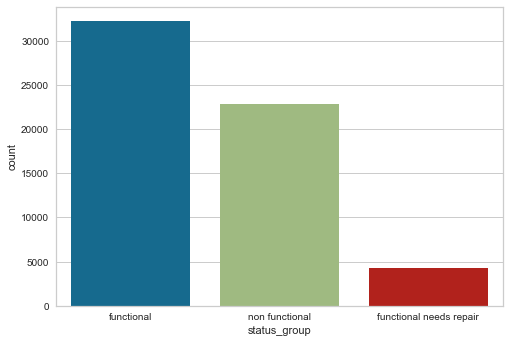

In [97]:
#Create figure to visualize class imbalance

sns.countplot(x='status_group', data=training_df)

Show distribution of pumps across Tanzania

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

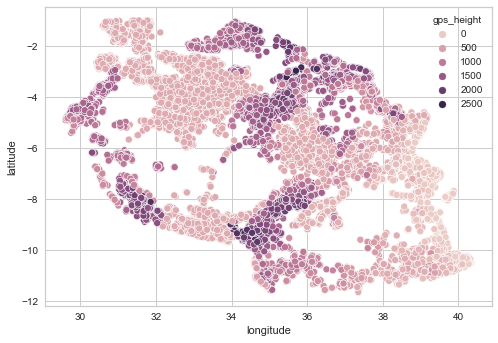

In [98]:
sns.scatterplot(x=X_train_df['longitude'], y=X_train_df['latitude'],
            hue=X_train_df['gps_height'])

# MODEL

### Model Evaluation Function

In [99]:
#Create model evaluation function to uniformly evaluate each model iteration

def model_evaluation(model, X_test_df, y_test, X_train_df, y_train, 
                     cmap='Blues', normalize='true', 
                     classes=['functional', 'non functional',
                                   'functional needs repair'], figsize=(14,7),
                     n=30):
    """Function evaluates any sci-kit learn classification model with a class-
    ification report, confusion matrix, ROCAUC curves, and training and test
    scores. Additionally displays feature importances of model.
    
    Arguments-
    
    model: any scikit learn classification model
    X_test_df: X test data
    y_test: Y test data
    X_train_df: X training data
    y_train: Y training data
    cmap: color map for confusion matrix, defaults to Blues
    normalize: normalize argument for plot_confusion_matrix, 
               defaults to 'true'
    classes: list of classes to display for ROCAUC graph
    figsize: figure size defaults to 14,7
    n: number of features to display for feature importance figure

    """
    y_pred_test = model.predict(X_test_df)
    print(metrics.classification_report(y_test, y_pred_test))
    
    fig,ax = plt.subplots(ncols=2, figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test_df,y_test, normalize='true', 
                                  ax=ax[0], cmap='Blues')
    
    visualizer = ROCAUC(model, classes=classes, ax=ax[1])
    visualizer.fit(X_train_df, y_train)
    visualizer.score(X_test_df, y_test)
    visualizer.show()
    
    plt.tight_layout()
    
    print(f"Training Score = {model.score(X_train_df,y_train):.2f}")
    print(f"Test Score = {model.score(X_test_df,y_test):.2f}")
    
    try: 
        feature_importance_df = pd.Series(model.feature_importances_,
                              index=X_train_df.columns)
        feature_importance_df.sort_values(ascending=True).tail(n).plot(
            kind='barh',figsize=figsize,title='Feature Importances',
            ylabel='Feature')
    except:
        pass
    
    return fig,ax

### Baseline Model (Dummy Classifier)

Create a baseline dummy classifier model as a starting point

                         precision    recall  f1-score   support

             functional       0.55      0.55      0.55      9678
functional needs repair       0.06      0.06      0.06      1295
         non functional       0.38      0.38      0.38      6847

               accuracy                           0.45     17820
              macro avg       0.33      0.33      0.33     17820
           weighted avg       0.45      0.45      0.45     17820



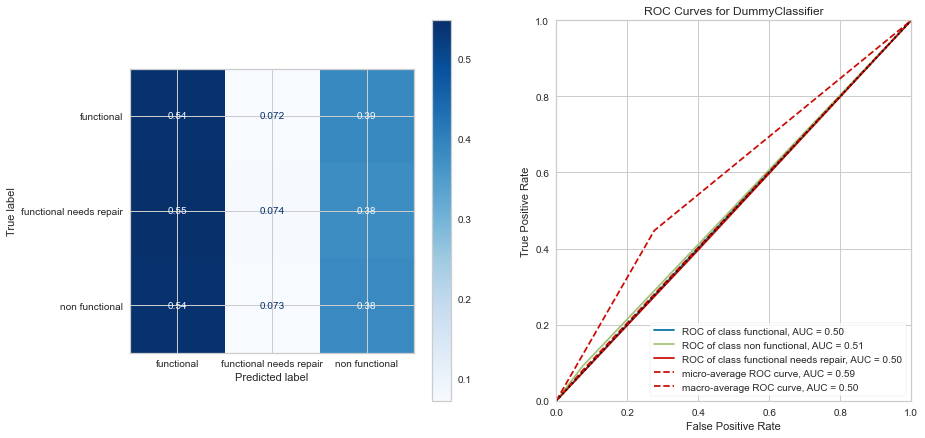

Training Score = 0.44
Test Score = 0.45


<Figure size 576x396 with 0 Axes>

In [100]:
#Create dummy classifier and evaluate

dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X_train_df,y_train)
model_evaluation(dummy_clf, X_test_df, y_test, X_train_df, y_train);

With an accuracy of 0.45 and f1 scores ranging from 0.08 to 0.55, the dummy classifier does no better than if one were to just guess the functional status group of the pump.

The confusion matrix above shows the discrepancy between the dummy classifier's predicted status group label for a given pump vs the true status group label. The dummy classifier does no better than guessing at random.

The ROCAUC figure above shows an AOC figure of 0.50, deeming the dummy classifier useless.

The mean accuracy scores (0.45 for the training data and 0.45 for the test data) above show that while the dummy classifier is not over fit, it has a very poor mean accuracy.

### RandomForestClassifier 1

For this task, I chose to first implement a RandomForest Classifier, as this model is well suited to this classification task

                         precision    recall  f1-score   support

             functional       0.81      0.86      0.83      9678
functional needs repair       0.49      0.35      0.41      1295
         non functional       0.81      0.79      0.80      6847

               accuracy                           0.79     17820
              macro avg       0.71      0.66      0.68     17820
           weighted avg       0.79      0.79      0.79     17820



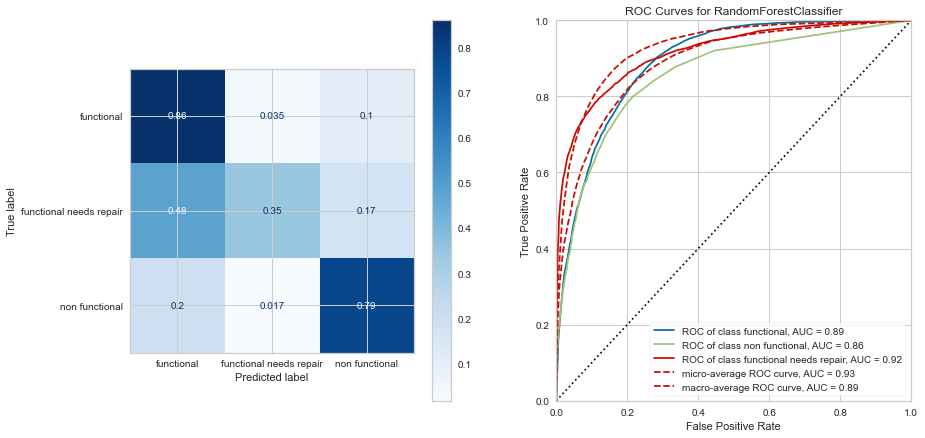

Training Score = 0.99
Test Score = 0.79


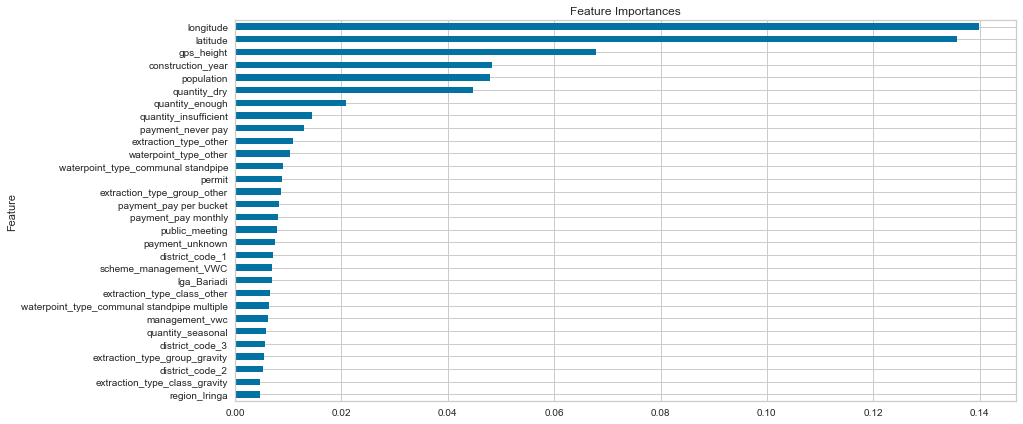

In [101]:
#Create randomforest model and evaluate

rf_1 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4)
rf_1.fit(X_train_df, y_train)
model_evaluation(rf_1, X_test_df, y_test, X_train_df, y_train);

With an accuracy of 0.79 and f1 scores of 0.41, 0.80, and 0.83,  the initial Random Forest does a far better job of predicting the status group of a given pump.

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The model does an excellent job predicting the `functional` and `non functional` statuses correctly (precision of 0.81 for each, and recall of 0.86, and 0.79 respectively). However, it struggles to accurately predict the `functional needs repair` status (precision of 0.49 and recall of 0.35).

The ROCAUC figure above shows an AOC figure of 0.89 for `functional`, 0.86 for `non functional`, and 0.92 for `functional needs repair`,  deeming the initial Random Forest model quite impressive.

The mean accuracy scores (0.99 for the training data and 0.79 for the test data) above show that the Random Forest is overfit. However, it does have an impressive mean accuracy score for the test data.

The feature importance figure shows how important each respective feature is to the model in predicting the status group for a given pump. `Longitude`, `latitude`, `gps height`, `population`, `quantity`, and `construction year` were deemed the most important.

### RandomForestClassifier 1: Hyperparameter Tuning

In this section we use GridSearchCV to tune the hyperparameters of the Random Forest in hopes of increasing recall scores, especially regarding the needs repair status.

In [102]:
X_train_df.shape

(41580, 330)

In [103]:
#Create parameters grid for use in the GridSearch

param_grid = {'criterion':['gini','entropy'],
              'min_samples_split':[4,6,8],
             'n_estimators':[500, 750, 1000],
             'max_depth':[3,6,10]}

#Create GridSearchCV instance, prioritizing recall
#and cross validating 3 times

grid_rf_1 = GridSearchCV(rf_1, param_grid=param_grid, scoring='recall_macro',
                         cv=3, n_jobs=-1, verbose=True)

grid_rf_1.fit(X_train_df, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 15.0min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, random_state=4),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 6, 10],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [500, 750, 1000]},
             scoring='recall_macro', verbose=True)

In [104]:
#Display best accuracy and best parameters of the GridSearch

print('Best Score: ')
print(grid_rf_1.best_score_)
print('Best Parameters: ')
print(grid_rf_1.best_params_)

Best Score: 
0.6704394897910269
Best Parameters: 
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 1000}


### RandomForestClassifier 2:

While the initial Random Forest was impressive, it struggled to correctly identify the `functional needs repair` status. The second iteration of the model will attempt to improve upon that.

                         precision    recall  f1-score   support

             functional       0.79      0.72      0.75      9678
functional needs repair       0.24      0.73      0.36      1295
         non functional       0.86      0.63      0.73      6847

               accuracy                           0.68     17820
              macro avg       0.63      0.69      0.61     17820
           weighted avg       0.77      0.68      0.71     17820



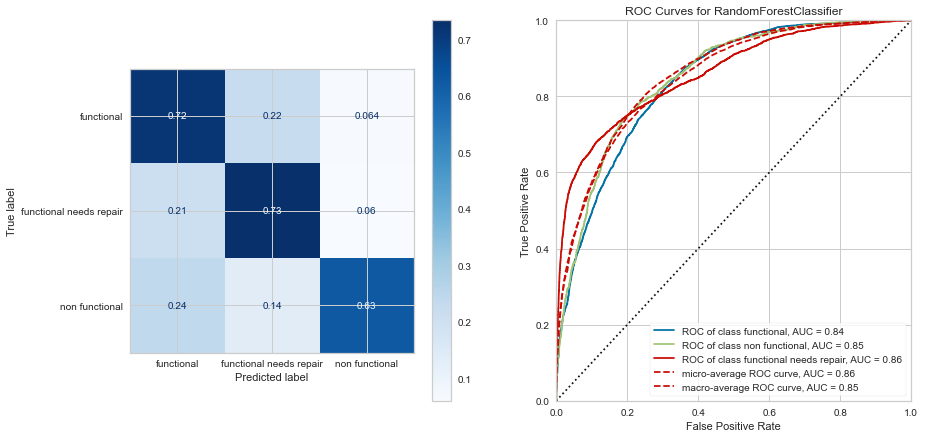

Training Score = 0.69
Test Score = 0.68


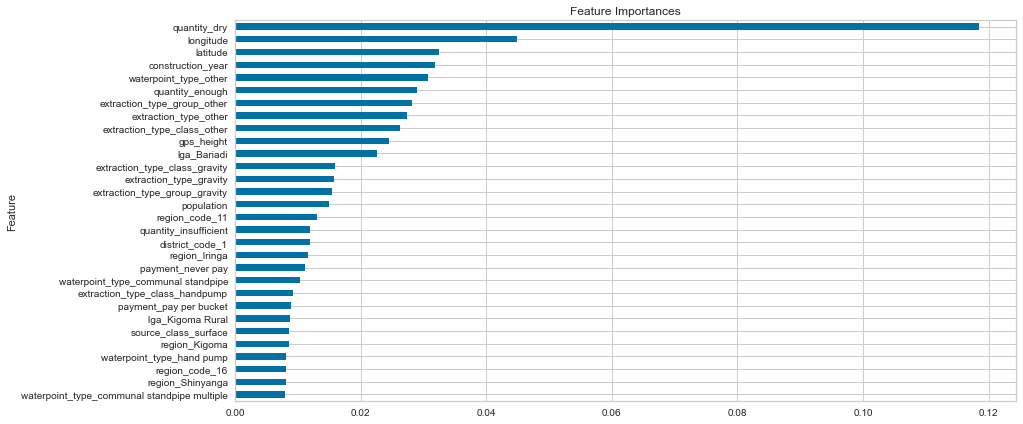

In [105]:
#Create new Random Forest utilizing best parameters from the GridSearch

rf_2 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4, **grid_rf_1.best_params_)
rf_2.fit(X_train_df, y_train)
model_evaluation(rf_2, X_test_df, y_test, X_train_df, y_train);

With an accuracy of 0.79 and f1 scores of 0.45, 0.80, and 0.83, the second iteration of the Random Forest has improved the f1 score of `functional needs repair`.

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The second iteration of the model does a drastically better job predicting the `functional needs repair` status with a recall of 0.73. However, the recall scores for `functional` and `non functional` have decreased marginally.

The ROCAUC figure above shows an AOC figure of 0.84 for functional, 0.85 for non functional, and 0.86 for functional needs repair, deeming the second iteration Random Forest model quite impressive but worse than the first.

The mean accuracy scores (0.69 for the training data and 0.68 for the test data) above show that this iteration of the model is no longer overfit.

The feature importance figure shows how important each respective feature is to the model in predicting the status group for a given pump. `Longitude`, `latitude`, `gps height`, `population`, `quantity`, and `construction year` were deemed the most important again.

### RandomForestClassifier 2: Hyperparameter Tuning

We will attempt to further improve the accuracy of the model by tuning hyperparameters again, in hopes of narrowing down the optimal parameters.

In [106]:
#Create parameters grid for use in the GridSearch

param_grid = {'criterion':['gini','entropy'],
              'min_samples_split':[1,2,4],
             'n_estimators':[1000,1250,1500],
             'max_depth':[10,15,20]}

#Create GridSearchCV instance, prioritizing recall
#and cross validating 3 times

grid_rf_2 = GridSearchCV(rf_2, param_grid=param_grid, scoring='recall_macro',
                         cv=3, n_jobs=-1, verbose=True)

grid_rf_2.fit(X_train_df, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 27.3min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy', max_depth=10,
                                              min_samples_split=4,
                                              n_estimators=1000, n_jobs=-1,
                                              random_state=4),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'min_samples_split': [1, 2, 4],
                         'n_estimators': [1000, 1250, 1500]},
             scoring='recall_macro', verbose=True)

In [107]:
#Display best score and best parameters from the GridSearch
print('Best Score: ')
print(grid_rf_2.best_score_)
print('Best Parameters: ')
print(grid_rf_2.best_params_)

Best Score: 
0.7027611300881719
Best Parameters: 
{'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 1000}


### RandomForestClassifier 3:

Create third iteration of the Random Forest using the parameters from the second GridSearch

                         precision    recall  f1-score   support

             functional       0.82      0.83      0.83      9678
functional needs repair       0.37      0.56      0.45      1295
         non functional       0.85      0.76      0.80      6847

               accuracy                           0.78     17820
              macro avg       0.68      0.72      0.69     17820
           weighted avg       0.80      0.78      0.79     17820



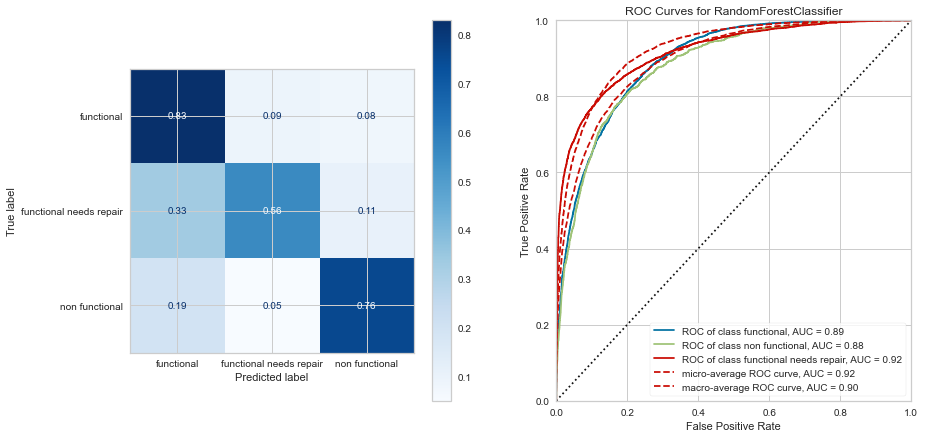

Training Score = 0.89
Test Score = 0.78


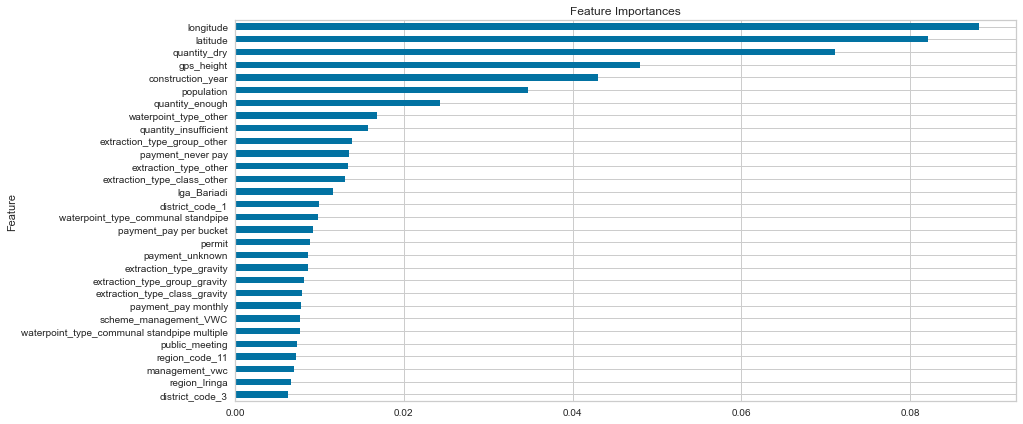

In [108]:
#Create and evaluate third randomforest model

rf_3 = RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                              random_state=4, **grid_rf_2.best_params_)
rf_3.fit(X_train_df, y_train)
model_evaluation(rf_3, X_test_df, y_test, X_train_df, y_train);

With an accuracy of 0.78 and f1 scores of 0.45, 0.80, and 0.83, the third iteration of the Random Forest has improved the overall accuracy of the model, `functional needs repair` recall, and reduced how overfit it is.

The confusion matrix above shows the discrepancy between the Random Forest's predicted status group label for a given pump vs the true status group label. The third iteration of the model does a better job predicting the `functional` and `non functional` statuses correctly (precision of 0.82 for the first, 0.85 for the latter, and recall of 0.83, and 0.76 respectively). It has also improved the recall for `functional needs repair`.

The ROCAUC figure above shows an AOC figure of 0.89 for functional, 0.88 for non functional, and 0.92 for functional needs repair, deeming the third iteration Random Forest model quite impressive and improved over the initial.

The mean accuracy scores (0.89 for the training data and 0.78 for the test data) above show that the Random Forest is still overfit. However, it has reduced the level of over fitting by improving the test mean accuracy.

The above figure shows how important each respective feature is to the model in predicting the status group for a given pump. `Longitude`, `latitude`, `gps height`, `population`, `quantity`, and `construction year` were deemed the most important again.

### XGBoostClassifier 1:

Next, I will create an XGBoost classifier to compare to the RandomForest

In [109]:
# Use SMOTENC to address class imbalance
smote_feats = [False]*len(numerical_cols) +[True]*len(categorical_features)

In [110]:
smote = SMOTENC(smote_feats)
X_train_sm,y_train_sm = smote.fit_sample(X_train_df,y_train)
y_train_sm.value_counts()

non functional             22581
functional needs repair    22581
functional                 22581
Name: status_group, dtype: int64

                         precision    recall  f1-score   support

             functional       0.81      0.80      0.80      9678
functional needs repair       0.33      0.52      0.41      1295
         non functional       0.82      0.74      0.78      6847

               accuracy                           0.76     17820
              macro avg       0.65      0.69      0.66     17820
           weighted avg       0.78      0.76      0.77     17820



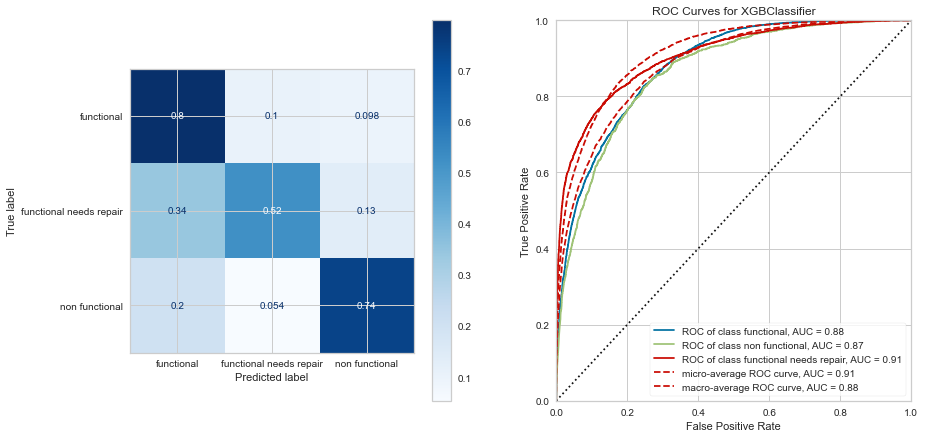

Training Score = 0.80
Test Score = 0.76


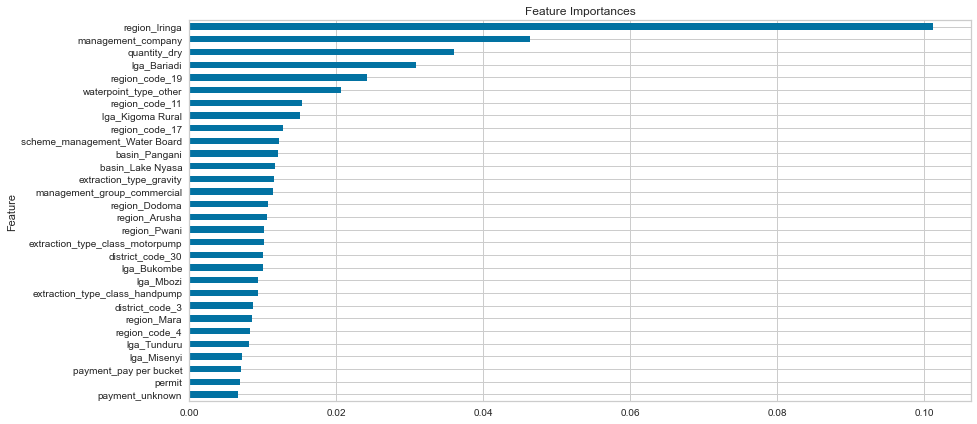

In [111]:
# Create and fit XGBClassifier on SMOTENC data, then evaluate

xgb = XGBClassifier()
xgb.fit(X_train_sm, y_train_sm)
model_evaluation(xgb, X_test_df, y_test, X_train_df, y_train);

The initial XGBoost model had an impressive test score accuracy of 0.76, compared to a training score accuracy of 0.80. This shows the model is quite accurate without being overfit. Additionally, the ROCAUC curves also had very high scores. However, like the random forest, it struggled with `functional needs repair` recall score (0.52).

The three most important features in the XGBoost model were `region`, `management company`, and ` quantity`, which differ significantly from the random forest models.

### XGBoostClassifier 1: Hyperparameter Tuning

In this section we use GridSearchCV to tune the hyperparameters of the XGBoost model in hopes of increasing recall scores, especially regarding the `functional needs repair` status.

In [112]:
#Create parameters grid for use in the GridSearch

param_grid = {'learning_rate': [0.1, 0.2],
                'max_depth': [6],
                'min_child_weight': [1, 2],
                'subsample': [0.5, 0.7],
                'n_estimators': [100]}

#Create GridSearchCV instance

grid_xgb = GridSearchCV(xgb, param_grid=param_grid,
                         cv=None, n_jobs=-1, verbose=True)

grid_xgb.fit(X_train_df, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 12.7min finished


GridSearchCV(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob', random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, subsample=1,
                                     tree

In [113]:
#Display best score and best parameters of the GridSearch

print('Best Score: ')
print(grid_xgb.best_score_)
print('Best Parameters: ')
print(grid_xgb.best_params_)

Best Score: 
0.7895622895622896
Best Parameters: 
{'learning_rate': 0.2, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.5}


### XGBoostClassifier 2:

                         precision    recall  f1-score   support

             functional       0.81      0.79      0.80      9678
functional needs repair       0.32      0.53      0.40      1295
         non functional       0.82      0.74      0.77      6847

               accuracy                           0.75     17820
              macro avg       0.65      0.69      0.66     17820
           weighted avg       0.78      0.75      0.76     17820



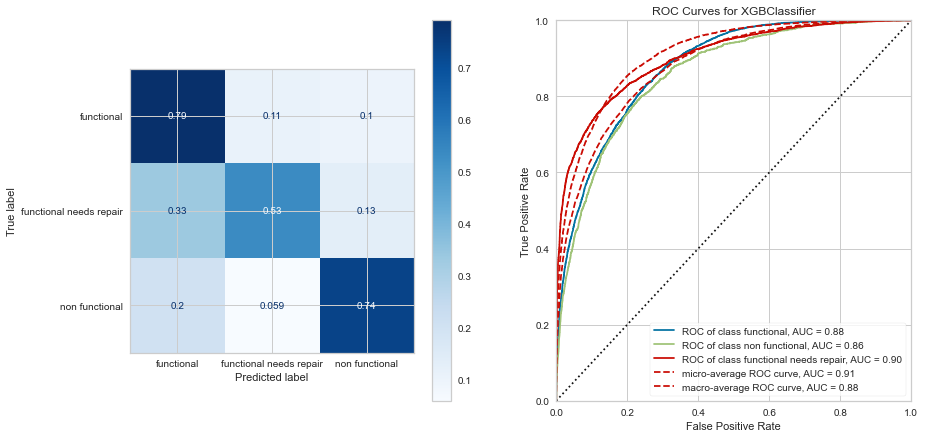

Training Score = 0.78
Test Score = 0.75


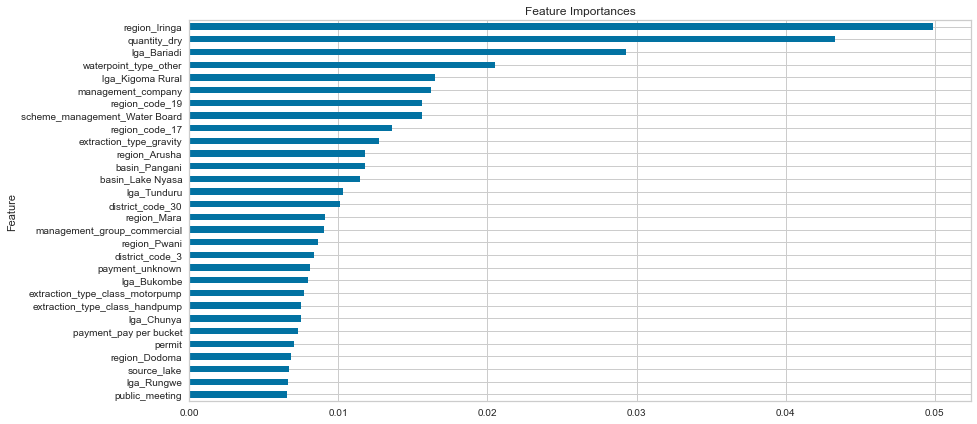

In [114]:
#Create and evaluate second XGB model using the identified parameters

xgb_2 = XGBClassifier(**grid_xgb.best_params_)
xgb_2.fit(X_train_sm, y_train_sm)
model_evaluation(xgb_2, X_test_df, y_test, X_train_df, y_train);

The second iteration of the XGBoost model actually performed worse than the first iteration, with a test accuracy of 0.75, and a `functional needs repair` recall score equal to the first.

# iNTERPRET

After comparing the models, I believe the third iteration of the random forest models, `rf_3`, is the most promising regarding addressing the business problem. While it does struggle with being over fit and correctly identifying `functional needs repair` pumps, it is much less over fit than its first iteration, and has impressive recall scores for `functional` and `non functional`. Additionally, it is much more interpretable than the XGBoost model.

Use LIME to interpret feature importances

In [115]:
#Create LIME instance

lime_explainer =LimeTabularExplainer(
    training_data=np.array(X_test_df),
    feature_names=X_train_df.columns,
    categorical_features= categorical_features, 
    class_names=['functional', 'non functional', 'functional needs repair'],
    mode='classification'
)

In [116]:
#Create random row choice generator

row = np.random.choice(range(len(X_test_df)))

In [117]:
#Create explainer instance for the test data and generate figure

exp = lime_explainer.explain_instance(X_test_df.iloc[row], rf_3.predict_proba,
                                      num_features=10, top_labels=3)
exp.show_in_notebook(show_table=True)

The LIME figure above confirms `quantity` as one of the most important features in determining status group.

In [118]:
#Recreate dataframe for creating visuals
interpret_training_df = training_df.copy()
interpret_training_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.00000000,2011-03-14,Roman,1390,Roman,34.93809275,-9.85632177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.00000000,2013-03-06,Grumeti,1399,GRUMETI,34.69876610,-2.14746569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.00000000,2013-02-25,Lottery Club,686,World vision,37.46066446,-3.82132853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.00000000,2013-01-28,Unicef,263,UNICEF,38.48616088,-11.15529772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.00000000,2011-07-13,Action In A,0,Artisan,31.13084671,-1.82535885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [119]:
#Address null values for features to be visualized

interpret_training_df['construction_year'].replace(0,
                                                   interpret_training_df['construction_year'].median(),
                                                   inplace=True)
interpret_training_df['longitude'].replace(0.000000, 
                                           interpret_training_df['longitude'].mean(),
                                           inplace=True)
interpret_training_df['latitude'].replace(-0.00000002,
                                          interpret_training_df['latitude'].mean(),
                                          inplace=True)
interpret_training_df['gps_height'].replace(0,
                                            interpret_training_df['gps_height'].median(),
                                            inplace=True)
interpret_training_df['population'].replace(0, 
                                            interpret_training_df['population'].median(),
                                            inplace=True)

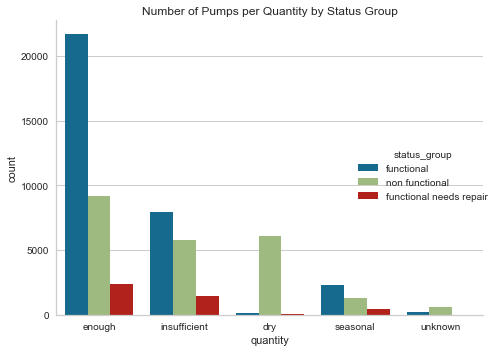

In [120]:
#Create visual interpreting quantity feature

sns.catplot(data=training_df, kind='count', x='quantity', hue='status_group')
plt.title('Number of Pumps per Quantity by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_quantity.png', dpi=300)

The figure above shows how as water quantity decreases, pumps are more likely to be non functional

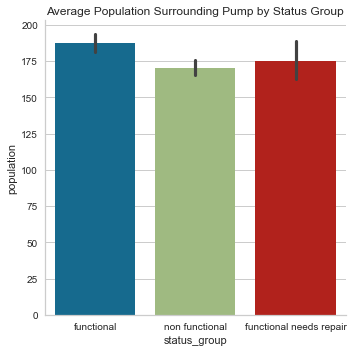

In [121]:
#Create visual to interpret population

sns.catplot(data=training_df, kind='bar', y='population', x='status_group')
plt.title('Average Population Surrounding Pump by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_population.png', dpi=300)

The figure above shows how pumps in areas of lower population may be more likely to be needing repair or non functional

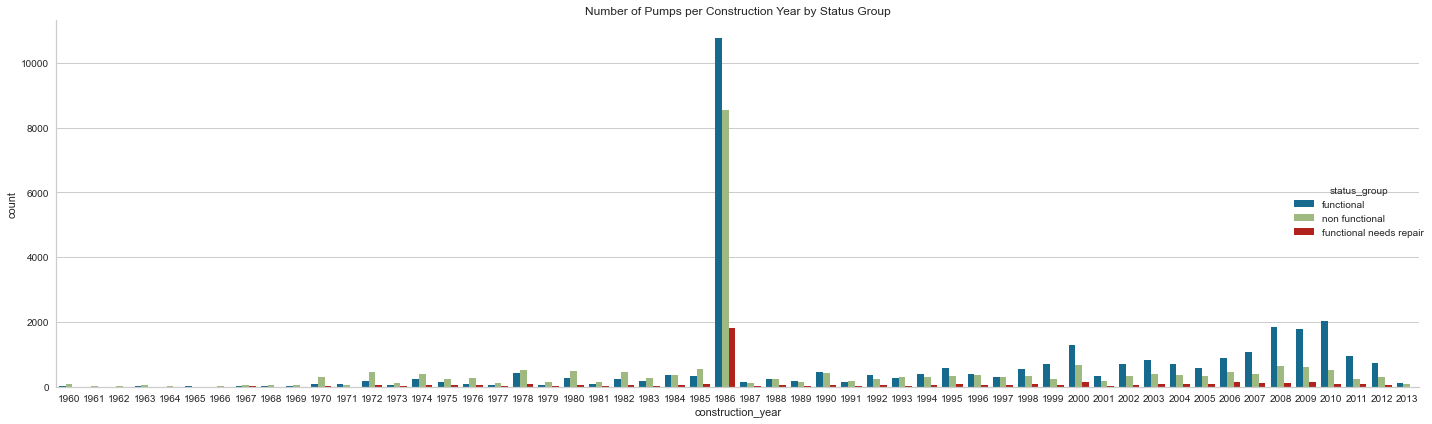

In [122]:
#Create visual to interpret construction year

sns.catplot(data=interpret_training_df, kind='count', x='construction_year',
            hue='status_group', orient='h', aspect=3, height=6)
plt.title('Number of Pumps per Construction Year by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_construction_year.png', dpi=300)

The figure above shows how older pumps are more likely to be nonfunctional or needing repair

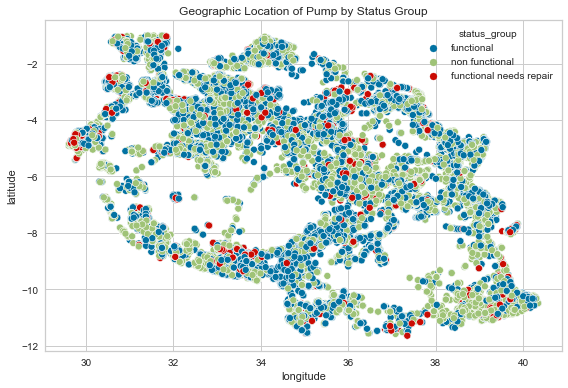

In [123]:
#Create visual to interpret location

sns.scatterplot(data=interpret_training_df, x='longitude', y='latitude',
                hue='status_group')
plt.title('Geographic Location of Pump by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_location_by_groups.png', dpi=300)

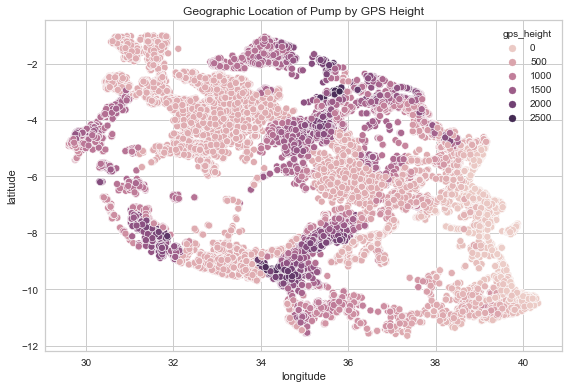

In [124]:
#Create visual to interpret location

sns.scatterplot(x=interpret_training_df['longitude'],
                y=interpret_training_df['latitude'],
                hue=interpret_training_df['gps_height'])
plt.title('Geographic Location of Pump by GPS Height')
plt.tight_layout()

plt.savefig('images/pumps_by_location_by_height.png', dpi=300)

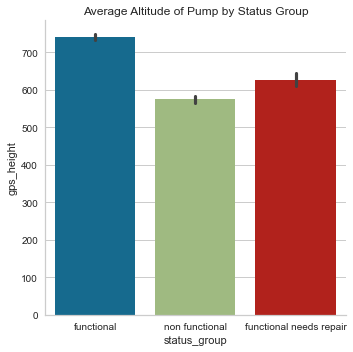

In [125]:
#Create visual to interpret location

sns.catplot(data=training_df, kind='bar', y='gps_height', x='status_group')
plt.title('Average Altitude of Pump by Status Group')
plt.tight_layout()

plt.savefig('images/pumps_by_avg_gps_height.png', dpi=300)

The figures above show that pumps in lower altitude areas may be more likely to be non functional

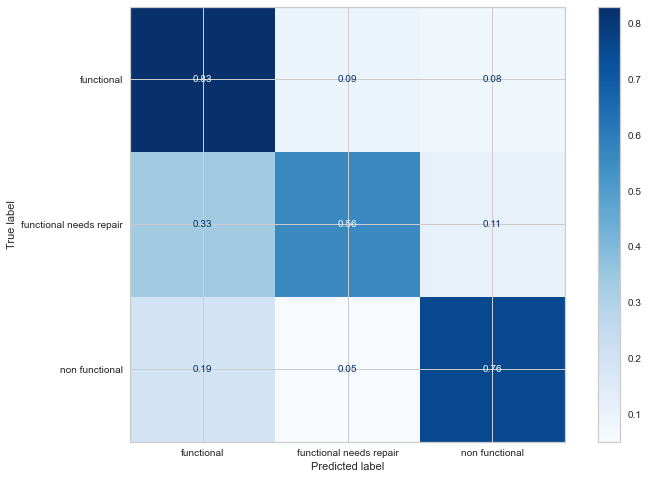

In [136]:
# Create individual confusion matrix for rf_3

fig,ax = plt.subplots(ncols=1, figsize=(12,8))
metrics.plot_confusion_matrix(rf_3, X_test_df,y_test, normalize='true', ax=ax,
                              cmap='Blues')
plt.savefig('images/rf3_confusion_matrix.png', dpi=1200)

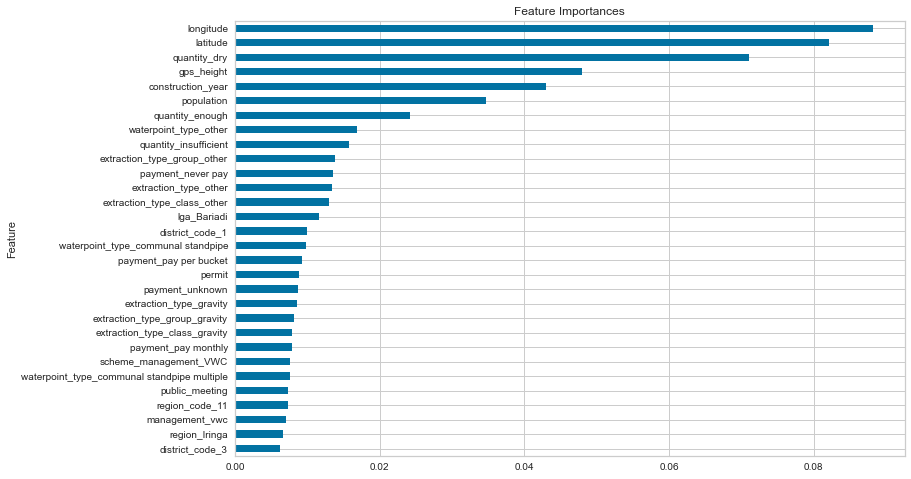

In [132]:
# Create individual feature importances chart for rf_3

feature_importance_df = pd.Series(rf_3.feature_importances_,
                              index=X_train_df.columns)
feature_importance_df.sort_values(ascending=True).tail(30).plot(
        kind='barh',figsize=(12,8),title='Feature Importances',
        ylabel='Feature')
plt.savefig('images/rf3_feature_importances.png', dpi=300)

# CONCLUSIONS & RECOMMENDATIONS

Based on this random forest classifier model, I would provide four recommendations to the Tanzanian Ministry of Water as they look to improve pump status prediction and maintenance efficiency:

- **Location** `Longitude`, `latitude`, and `gps height` were some of the most important features in the random forest classifier. Based on the analysis, pumps in lower altitude areas may be more likely to need repair or be non functional. The Ministry should focus resources on lower altitude pumps.

- **Quantity** `Quantity` was one of the most important features in the random forest classifier. Analysis showed that pumps with lower quantities of water were more likely to be non functional or needing repair. The Ministry should focus resources on pumps with low quantities of water.

- **Population** `Population` was one of the most important features in the random forest classifier. Analysis showed that pumps in lower population areas may be more likely to be non functional or needing repairs. The Ministry of Water should focus resources on low population areas, as they may not be receiving enough.

- **Construction Year** `Construction Year` was one of the most important features in the random forest classifier. Analysis showed that older pumps may be more likely to be nonfunctional or needing repair. The Ministry should focus resources on modernizing older pumps.

However, the random forest model and analysis are not complete solutions, nor are they perfect. The final model still struggles with correctly identifying pumps classified as `functional needs repair`, too often mistaking them for `functional` pumps. But as `functional needs repair` pumps make up a very small part of the data set, I believe this to be a tolerable risk and that the model is accurate to a degree that makes it useful for the Ministry of Water as a tool to improve pump status prediction and maintenance efficiency.

I could improve this analysis in the future by further transforming and scrubbing the data to create more helpful features and cleaner data, further tweaking the hyperparameters of the model, or by experimenting with other models like a LightGBM or CatBoost model.